# Softmax Regression and KNN
- [Multi-Class Classification using Softmax Regression](#MCSR)
- [Binary Classification using KNN Classifier](#BCKNN)
- [Multi-Class Classification using KNN Classifier](#MCKNN)
- [Regression using KNN Regressor on California Housing Dataset](#RKNN)

In [39]:
import numpy as np
from pprint import pprint

from sklearn.datasets import fetch_california_housing

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV, cross_val_predict, learning_curve
from sklearn.metrics import log_loss, ConfusionMatrixDisplay, classification_report, make_scorer, f1_score, mean_squared_error

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', figsize=(8, 6))

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [5]:
from sklearn.datasets import fetch_openml
X_pd, y_pd = fetch_openml('mnist_784', version=1, return_X_y=True)

X = X_pd.to_numpy()
y = y_pd.to_numpy()

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

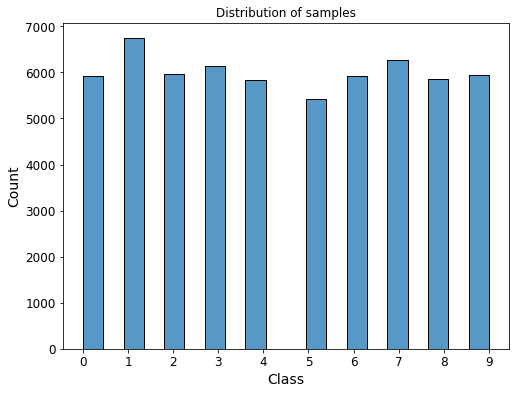

In [6]:
plt.figure()
sns.histplot(data=np.int8(y_train), binwidth=0.45, bins=11)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of samples')
plt.show()

## <a id="MCSR"></a>Multi-Class Classification Using Softmax Regression 

In [7]:
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('logreg', LogisticRegression(multi_class='multinomial', solver='sag'))
])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(multi_class='multinomial', solver='sag'))])

In [9]:
print(pipe[-1].coef_.shape)
print(pipe[-1].intercept_.shape)
print(pipe[-1].classes_)

(10, 784)
(10,)
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


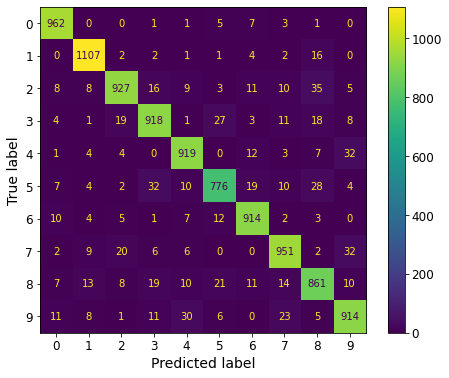

In [10]:
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)

In [11]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.94      0.90      0.92      1032
           3       0.91      0.91      0.91      1010
           4       0.92      0.94      0.93       982
           5       0.91      0.87      0.89       892
           6       0.93      0.95      0.94       958
           7       0.92      0.93      0.92      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.91      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



Following is an attempt to cross-validate the same regression model using `LogisticRegressionCV()`, but it **takes more than 3 hours to finish.** For now, just commenting out the lines.

In [ ]:
# scorer = make_scorer(f1_score, average='micro')
# pipe = Pipeline([
#     ('scaler', StandardScaler()), 
#     ('logreg', LogisticRegressionCV(cv=5, multi_class='multinomial', solver='sag', scoring=scorer, max_iter=100, ranclass_weight=dom_state=1729))
# ])
# pipe.fit(X_train, y_train)

## <a id="BCKNN"></a>Binary Classification using KNN ( K Nearest Neighbors ) Classifier

In [12]:
# Initialize new variable names with all -1
y_train_0 = -1 * np.ones(y_train.shape[0])
y_test_0 = -1 * np.ones(y_test.shape[0])

# Find indices of digit 0 image
indx_0 = np.where(y_train == '0')
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

print(y_train)
print(y_train_0)

['5' '0' '4' ... '5' '6' '8']
[-1.  1. -1. ... -1. -1. -1.]


### Using PCA To Reduce Dimension

**To 2 Features**

In [20]:
pipe_pca_2d = make_pipeline(MinMaxScaler(), PCA(n_components=2))
X_train_pca_2d = pipe_pca_2d.fit_transform(X_train)

<AxesSubplot:>

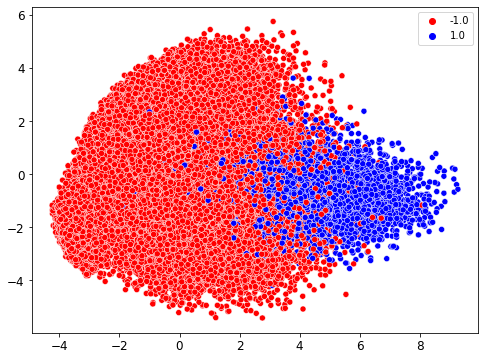

In [21]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(['r', 'b'])
sns.scatterplot(x = X_train_pca_2d[:, 0], y = X_train_pca_2d[:, 1], hue=y_train_0, palette=cmap)

**To 3 Features ( We won't be using this one )**

In [ ]:
# pipe_pca_3d = make_pipeline(MinMaxScaler(), PCA(n_components=3))
# X_train_pca_3d = pipe_pca_3d.fit_transform(X_train)

# Commenting out, since this could impact the rendering of the notebook.

# from matplotlib.colors import ListedColormap
# import plotly.express as px
# cmap = ListedColormap(['r', 'b'])
# px.scatter_3d(x = X_train_pca_3d[:, 0], y = X_train_pca_3d[:, 1], z = X_train_pca_3d[:, 2], 
#               color=y_train_0, color_discrete_map=cmap, opacity=0.5)

**Pipeline**

In [25]:
pipe_clf_pca_2d = make_pipeline(pipe_pca_2d, KNeighborsClassifier(n_neighbors=3))

**Creating a Small Dataset**

In [26]:
# Train 10 samples (first 5 from negative class and last 5 from positive class)

index_neg = np.argsort(y_train_0)[:5]
index_pos = np.argsort(y_train_0)[-1:-6:-1]
print(f"Positive classes: {y_train_0[index_pos]}")
print(f"Negative classes: {y_train_0[index_neg]}")


# Create a small dataset
X = np.vstack((X_train[index_pos, :], X_train[index_neg, :]))
y = np.hstack((y_train_0[index_pos], y_train_0[index_neg]))
print(X.shape, y.shape)

Positive classes: [1. 1. 1. 1. 1.]
Negative classes: [-1. -1. -1. -1. -1.]
(10, 784) (10,)


**Applying PCA on the small dataset and plotting the transformed points**

<AxesSubplot:>

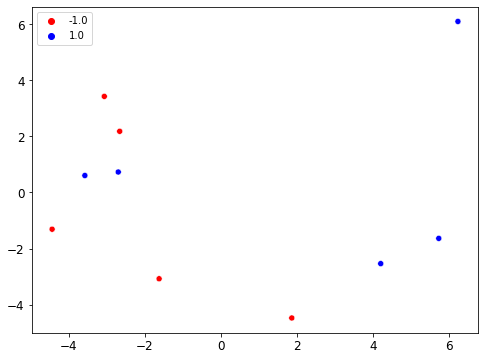

In [27]:
pipe_clf_pca_2d.fit(X, y)

# Plot them X (after applying PCA) with corresponding y.
X_reduced = pipe_clf_pca_2d[0].transform(X)

cmap = ListedColormap(['r', 'b'])
sns.scatterplot(X_reduced[:, 0], y=X_reduced[:, 1], marker='o', hue=y, palette=cmap)

**Predict from the model**

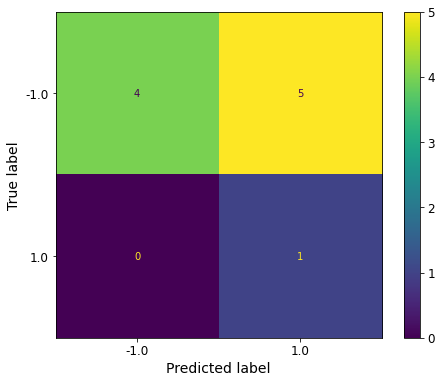

In [28]:
y_hat_0 = pipe_clf_pca_2d.predict(X_test[:10, :])
ConfusionMatrixDisplay.from_predictions(y_test_0[:10], y_hat_0)

### Not Using PCA

Using GridSearchCV to tune the hyper-parameters. 
**NOTE :** Takes a long time to run

In [33]:
pipe_knn = make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=1))
grid_k = {'kneighborsclassifier__n_neighbors': [1,3,5,7,9,11]}

cv = GridSearchCV(pipe_knn, param_grid=grid_k, scoring='precision', cv=5)
cv.fit(X_train, y_train_0)

print(cv)

In [ ]:
print(cv.cv_results_)

In [ ]:
print(cv.best_params_)

In [ ]:
pipe_knn = make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=7))
pipe_knn.fit(X_train, y_train_0)

In [ ]:
y_hat_0 = pipe_knn.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test_0, y_hat_0)

## <a id="MCKNN"></a>Multi-Class Classification using KNN Classifier

**Reuse the pipe created earlier**. The only difference is the data passed into it. Before we were using the `X_train_0`, `y_train_0`, etc. dataset. Now, we pass the entire dataset i.e `X_train`, `y_train`, etc.

In [34]:
pipe_knn.fit(X_train, y_train) 
y_hat = pipe_knn.predict(X_test)

pipe_knn.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

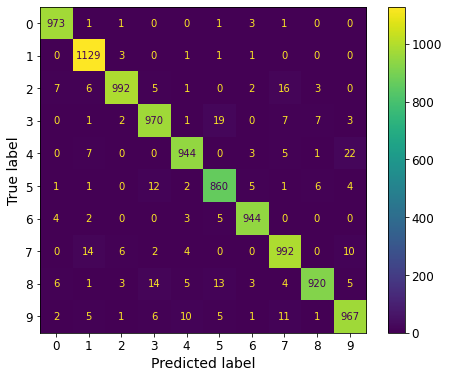

In [35]:
ConfusionMatrixDisplay.from_predictions(y_test, y_hat)

In [36]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.97      0.99      0.98      1135
           2       0.98      0.96      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.96      0.97       982
           5       0.95      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.98      0.94      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



## <a id="RKNN"></a>Regression using KNN Regressor on California Housing Dataset

In [40]:
X, y = fetch_california_housing(return_X_y=True)
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)
print(X_train.shape, X_test.shape)

(20640, 8) (20640,)
(14448, 8) (6192, 8)


Ensure that before the KNN model **is always scaled accordingly**. If not, it won't work as expected.

In [41]:
pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('knn', KNeighborsRegressor(n_neighbors=2))
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

error = mean_squared_error(y_test, y_pred, squared=False)
print(error)

0.6767822465759739


**Hyper-Parameter Tuning**

In [42]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('knn', KNeighborsRegressor(n_neighbors=2))])
gs = GridSearchCV(pipe, param_grid={'knn__n_neighbors': list(range(1, 31))}, cv=10, n_jobs=1, return_train_score=True)
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('knn',
                                        KNeighborsRegressor(n_neighbors=2))]),
             n_jobs=1,
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30]},
             return_train_score=True)

In [43]:
gs.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('knn', KNeighborsRegressor(n_neighbors=6))])

In [44]:
pred = gs.best_estimator_.predict(X_test)
error = mean_squared_error(y_test, pred, squared=False)
print("RMSE value for k is: ", error)

RMSE value for k is:  0.6255268557053962
